In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
train_root = "/content/drive/MyDrive/train"

Mounted at /content/drive


In [ ]:
import os
file_path = "/content/drive/MyDrive/train/label/train_45.png"
print("File exists:", os.path.exists(file_path))

File exists: True


In [ ]:
!pip install segmentation-models-pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

In [ ]:
class LEVIRTileDataset(Dataset):
    def __init__(self, root_dir, tile_size=256, transforms=None):
        self.A_dir = os.path.join(root_dir, "A")
        self.B_dir = os.path.join(root_dir, "B")
        self.L_dir = os.path.join(root_dir, "label")
        self.files = sorted(os.listdir(self.A_dir))
        self.tile_size = tile_size
        self.transforms = transforms

        #Precompute tile coordinates for all images
        self.tiles = []
        for idx, fname in enumerate(self.files):
            img_path = os.path.join(self.A_dir, fname)
            img = cv2.imread(img_path)
            if img is None:
                raise FileNotFoundError(f"Image not found or unreadable at {img_path}")
            h, w = img.shape[:2]
            x_steps = int(np.ceil(w / tile_size))
            y_steps = int(np.ceil(h / tile_size))
            for y in range(y_steps):
                for x in range(x_steps):
                    self.tiles.append((idx, x * tile_size, y * tile_size))

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        img_idx, x, y = self.tiles[idx]
        fname = self.files[img_idx]

        img_A_path = os.path.join(self.A_dir, fname)
        img_B_path = os.path.join(self.B_dir, fname)
        mask_path = os.path.join(self.L_dir, fname)

        img_A = cv2.imread(img_A_path)
        img_B = cv2.imread(img_B_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        #Errorhandling
        if img_A is None:
            raise FileNotFoundError(f"Image A not found at index {img_idx}, path {img_A_path}")
        if img_B is None:
            raise FileNotFoundError(f"Image B not found at index {img_idx}, path {img_B_path}")
        if mask is None:
            raise FileNotFoundError(f"Mask not found at index {img_idx}, path {mask_path}")

        #Croppad as needed
        def crop_with_padding(img, x, y, size):
            h, w = img.shape[:2]
            if len(img.shape) == 3:
                tile = np.zeros((size, size, img.shape[2]), dtype=img.dtype)
            else:
                tile = np.zeros((size, size), dtype=img.dtype)
            x2, y2 = min(x + size, w), min(y + size, h)
            tile[:y2 - y, :x2 - x] = img[y:y2, x:x2]
            return tile

        img_A_tile = crop_with_padding(img_A, x, y, self.tile_size)
        img_B_tile = crop_with_padding(img_B, x, y, self.tile_size)
        mask_tile = crop_with_padding(mask, x, y, self.tile_size)

        #Normalize
        img_A_tile = cv2.cvtColor(img_A_tile, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        img_B_tile = cv2.cvtColor(img_B_tile, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        mask_tile = (mask_tile > 127).astype(np.float32)  # binary mask

        img = np.concatenate([img_A_tile, img_B_tile], axis=-1)  # (H,W,6)

        #Apply optional transforms
        if self.transforms:
            augmented = self.transforms(image=img, mask=mask_tile)
            img, mask_tile = augmented["image"], augmented["mask"]

        img = np.transpose(img, (2, 0, 1))  # (C,H,W)
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask_tile, dtype=torch.float32)


In [ ]:
#Augmentations
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])


In [ ]:
#Dataset + DataLoader
train_dataset = LEVIRTileDataset(train_root, transforms=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

print(" Dataset loaded:", len(train_dataset), "tiles")

 Dataset loaded: 7140 tiles


In [ ]:
#Model + Loss + Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=6,   #A+B stacked
    classes=1,
).to(device)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
# BCE + Dice combined
bce = nn.BCEWithLogitsLoss()
dice = smp.losses.DiceLoss(mode="binary")
def criterion(outputs, targets):
    return bce(outputs, targets) + dice(outputs, targets)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Mixed precision
scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-4099378434.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
#Training
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        masks = masks.unsqueeze(1)  # [B,1,H,W]

        optimizer.zero_grad()

        # New AMP API
        with torch.amp.autocast("cuda"):
            outputs = model(imgs)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training finished on A100!")


Epoch [1/5], Loss: 0.2753
Epoch [2/5], Loss: 0.2685
Epoch [3/5], Loss: 0.2652
Epoch [4/5], Loss: 0.2476
Epoch [5/5], Loss: 0.2473
Training finished on A100!


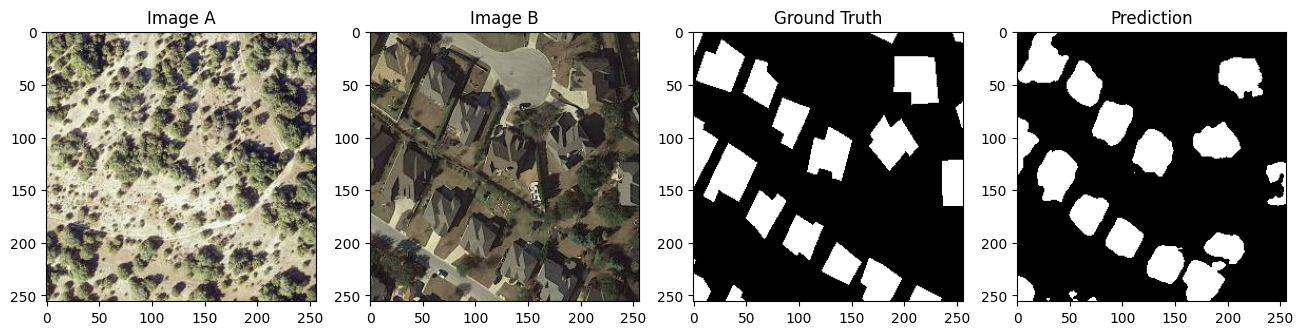

In [ ]:
def visualize_patch(model, dataset, device, idx=0):
    model.eval()
    img, mask = dataset[idx]
    mask = mask.numpy()

    with torch.no_grad():
        inp = img.unsqueeze(0).to(device)
        pred = model(inp)
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()

    pred_bin = (pred > 0.5).astype(np.uint8)

    img_np = img.numpy().transpose(1,2,0)
    img_A, img_B = img_np[:,:,:3], img_np[:,:,3:]

    fig, axs = plt.subplots(1, 4, figsize=(16,6))
    axs[0].imshow(img_A); axs[0].set_title("Image A")
    axs[1].imshow(img_B); axs[1].set_title("Image B")
    axs[2].imshow(mask, cmap="gray"); axs[2].set_title("Ground Truth")
    axs[3].imshow(pred_bin, cmap="gray"); axs[3].set_title("Prediction")
    plt.show()


visualize_patch(model, train_dataset, device, idx=210)

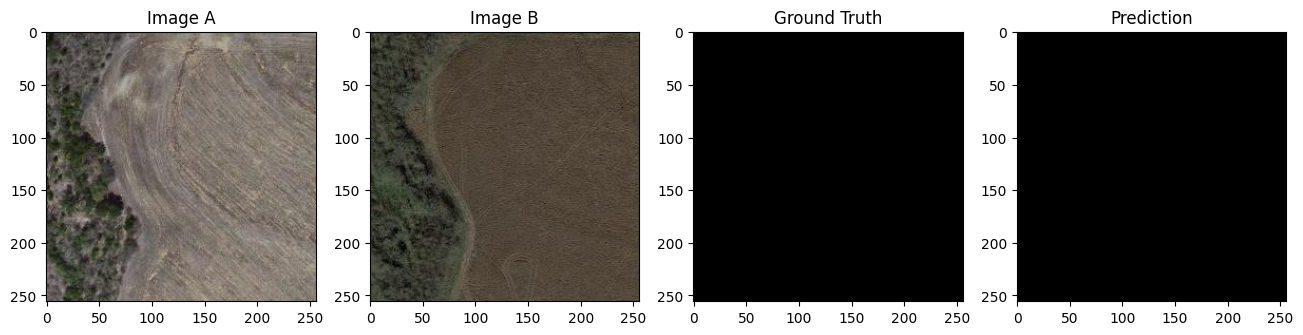

In [ ]:
visualize_patch(model, train_dataset, device, idx=2110)

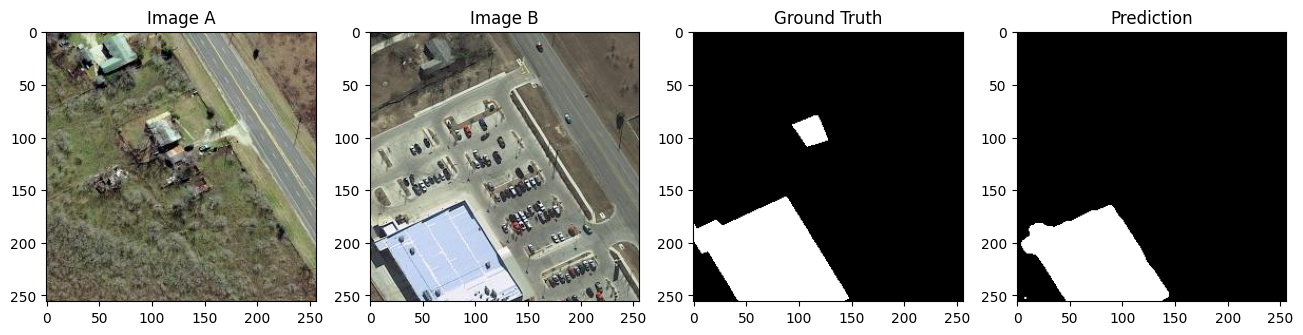

In [ ]:
visualize_patch(model, train_dataset, device, idx=3319)

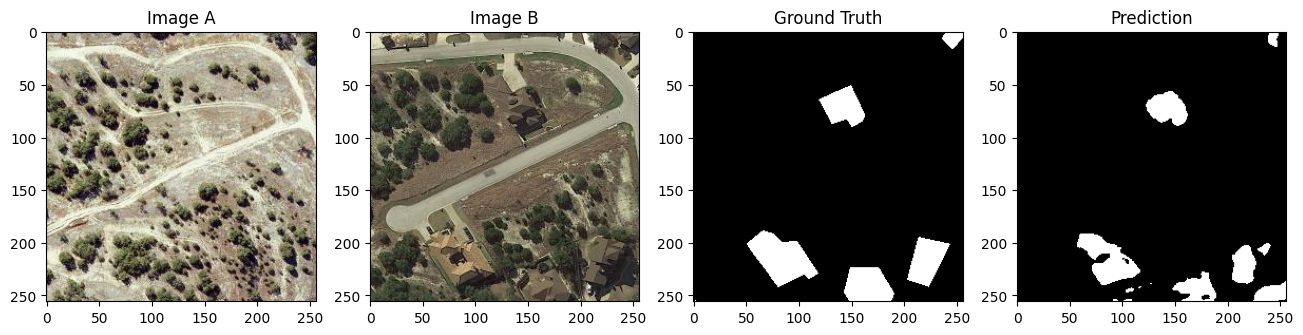

In [ ]:
visualize_patch(model, train_dataset, device, idx=7110)